In [1]:
import argparse
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import matplotlib.patches as patches


import scipy.io
import scipy.misc

import h5py
import numpy as np
import pandas as pd

import PIL
import math

import tensorflow as tf
from keras import backend as K
from keras.layers import ( Input, Add, Dense, Activation, 
  ZeroPadding2D, BatchNormalization, Flatten, Conv2D, 
  AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, Dropout, Reshape )

from keras.layers.advanced_activations import LeakyReLU, ELU
  
from keras.models import load_model, Model, Sequential
from keras.preprocessing import image

from keras.initializers import glorot_uniform

from keras.optimizers import SGD, Adam, RMSprop

from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, LambdaCallback, TerminateOnNaN

from keras.applications import *

from keras.layers.merge import concatenate
from keras import regularizers


from google.colab import drive
drive.mount('/content/gdrive')
!ls "/content/gdrive/My Drive/Colab"

resizedWidth = 384
gridCount = 12

Using TensorFlow backend.


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
'Create Datasets.ipynb'   font			  model_data
 datasets		 'Hair Detection.ipynb'   yad2k


In [0]:
def loadDatasets():
  hf = h5py.File("/content/gdrive/My Drive/Colab/datasets/hairData.h5", "r")
  pixel = np.array(hf.get("hair_data"))
  location = np.array(hf.get("hair_target"))
  hf.close()
  
  trainDataNum = 750
  
  trainingX = pixel[:trainDataNum]
  trainingY = location[:trainDataNum]
  testingX = pixel[trainDataNum:]
  testingY = location[trainDataNum:]
  
  return trainingX, trainingY, testingX, testingY

In [3]:
X_train, Y_train, X_test, Y_test = loadDatasets()
print("X_train shape =", X_train.shape)
print("Y_train shape =", Y_train.shape)
print("X_test shape =", X_test.shape)
print("Y_test shape =", Y_test.shape)

X_train = (X_train - 0.5) * 2.0
X_test = (X_test - 0.5) * 2.0


X_train shape = (750, 384, 384, 3)
Y_train shape = (750, 12, 12, 8)
X_test shape = (50, 384, 384, 3)
Y_test shape = (50, 12, 12, 8)


In [4]:
yolo_model = DenseNet121(input_shape=(resizedWidth, resizedWidth, 3), include_top=False)
yolo_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 384, 384, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 390, 390, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 192, 192, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 192, 192, 64) 256         conv1/conv[0][0]                 
_____________________________________

In [5]:
finalLayerOutput = yolo_model.layers[-1].output

x = BatchNormalization()(finalLayerOutput)
x = ELU(alpha=0.1)(x)
x = Conv2D(512, (3,3), strides=(1,1), padding='same', use_bias=False, kernel_initializer=glorot_uniform())(x)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)
x = ELU(alpha=0.1)(x)
x = Conv2D(256, (3,3), strides=(1,1), padding='same', use_bias=False, kernel_initializer=glorot_uniform())(x)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)
x = ELU(alpha=0.2)(x)
x = Conv2D(128, (3,3), strides=(1,1), padding='same', use_bias=False,kernel_initializer=glorot_uniform())(x)
x = Dropout(0.6)(x)

# modify the final layer
newPredictionLayer = Conv2D(8, (1,1), strides=(1,1), padding = "same", name = "final", kernel_initializer=glorot_uniform(),kernel_regularizer=regularizers.l2(0.01),activity_regularizer=regularizers.l1(0.01))(x)


firstLayer = yolo_model.layers[0].input

customModel = Model(firstLayer, newPredictionLayer)
customModel.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 384, 384, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 390, 390, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 192, 192, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 192, 192, 64) 256         conv1/conv[0][0]            

In [0]:
# load existing model weights
# yolo_model = load_model("/content/gdrive/My Drive/Colab/model_data/yolo.h5")

In [0]:
# # modify the final layer
# newPredictionLayer = yolo_model.get_layer("leaky_re_lu_22").output
# # newPredictionLayer = Conv2D(512, (3,3), strides=(1,1), padding="same", name="newConv1", kernel_initializer=glorot_uniform(seed = 0))(newPredictionLayer)
# # newPredictionLayer = BatchNormalization(axis = 3, name="newNormal1")(newPredictionLayer)
# # newPredictionLayer = LeakyReLU(name="newLeakyRelu1")(newPredictionLayer)

# newPredictionLayer = Conv2D(8, (1,1), strides=(1,1), padding = "same", name = "final", kernel_initializer=glorot_uniform(seed = 0))(newPredictionLayer)


# firstLayer = yolo_model.get_layer("input_1").input

# customModel = Model(firstLayer, newPredictionLayer)
# customModel.summary()
  
  

In [0]:
# with tf.Session() as sess:
#   x = tf.Variable([1,8,3])
#   y = tf.Variable([7,3,9])
  
#   z = x - y
  
# #   w = tf.Variable([
# #       [1, 8 ,3],
# #       [7, 3, 9]
# #   ])
  
# #   p = tf.reduce_max(w, [0])

#   w = tf.Variable(
#     [6,5,4,3,2,1]
#   )
  
#   o = tf.Variable(
#     [9,1,9,1,9,1]
#   )
  
#   p = K.maximum(w, 0)
  
#   p = o > 5
  
#   v = 1 - p
  
#   init = tf.global_variables_initializer()
  
#   sess.run(init)
#   print(sess.run(p))  
#   print(sess.run(v))

In [0]:
# customModel.load_weights("/content/gdrive/My Drive/Colab/model_data/hairDetection.h5")


def IOU_loss_confidence(pred_x, pred_y, pred_w, pred_h, 
                        true_x, true_y, true_w, true_h):
  """
  Used for calculating the confidence score between pred_box and true box
  """

  epi = 1e-6
  
  pred_topX = pred_x - pred_w / 2
  pred_topY = pred_y - pred_h / 2
  pred_botX = pred_x + pred_w / 2
  pred_botY = pred_y + pred_h / 2

  true_topX = true_x - true_w / 2
  true_topY = true_y - true_h / 2
  true_botX = true_x + true_w / 2
  true_botY = true_y + true_h / 2
  
  
  xi1 = K.maximum(pred_topX, true_topX)
  yi1 = K.maximum(pred_topY, true_topY)
  
  xi2 = K.minimum(pred_botX, true_botX)
  yi2 = K.minimum(pred_botY, true_botY)
  
  inter_area = K.maximum((yi2 - yi1), 0) * K.maximum((xi2 - xi1), 0)
  
  box1_area = (pred_botX - pred_topX) * (pred_botY - pred_topY)
  box2_area = (true_botX - true_topX) * (true_botY - true_topY)
  union_area = box1_area + box2_area - inter_area + epi
  
  iou = inter_area / union_area

  return iou
  
  

def custom_loss(y_true, y_pred):
  """
  Data Format
  
  12 x 12 x 8
  
  8 = [confidence score, center x, center y, width, height, class1, class2, class3]

  Details of YOLO loss algorithm:
  
  https://medium.com/@jonathan_hui/real-time-object-detection-with-yolo-yolov2-28b1b93e2088,
  
  https://hackernoon.com/understanding-yolo-f5a74bbc7967

  """
  
  trueConf = K.reshape(y_true[:, :, :, 0], [-1])
  trueCenterX = K.reshape(y_true[:, :, :, 1], [-1])
  trueCenterY = K.reshape(y_true[:, :, :, 2], [-1])
  trueWidth = K.reshape(y_true[:, :, :, 3], [-1])
  trueHeight = K.reshape(y_true[:, :, :, 4], [-1])
  trueClass1 = K.reshape(y_true[:, :, :, 5], [-1])
  trueClass2 = K.reshape(y_true[:, :, :, 6], [-1])
  trueClass3 = K.reshape(y_true[:, :, :, 7], [-1])
  
  predConf = K.reshape(y_pred[:, :, :, 0], [-1])
  predCenterX = K.reshape(y_pred[:, :, :, 1], [-1])
  predCenterY = K.reshape(y_pred[:, :, :, 2], [-1])
  predWidth = K.reshape(y_pred[:, :, :, 3], [-1])
  predHeight = K.reshape(y_pred[:, :, :, 4], [-1])
  predClass1 = K.reshape(y_pred[:, :, :,  5], [-1])
  predClass2 = K.reshape(y_pred[:, :, :,  6], [-1])
  predClass3 = K.reshape(y_pred[:, :, :, 7], [-1])
  
  
  responsibleBoxIndices = tf.equal(trueConf, 1) 
  unresponsibleBoxIndices = tf.not_equal(trueConf, 1) 

  
  responsibleIOU = IOU_loss_confidence(
      tf.boolean_mask(predCenterX, responsibleBoxIndices),
      tf.boolean_mask(predCenterY, responsibleBoxIndices),
      tf.boolean_mask(predWidth, responsibleBoxIndices),
      tf.boolean_mask(predHeight, responsibleBoxIndices),
      
      tf.boolean_mask(trueCenterX, responsibleBoxIndices),
      tf.boolean_mask(trueCenterY, responsibleBoxIndices),
      tf.boolean_mask(trueWidth, responsibleBoxIndices),
      tf.boolean_mask(trueHeight, responsibleBoxIndices)
  )
  
  object_detections = K.cast(responsibleIOU > 0.7, K.dtype(responsibleIOU))
  
  object_scale = 5
  no_object_scale = 1
  class_scale = 1
  coordinates_scale = 1
      
  no_object_weights = (no_object_scale * (tf.boolean_mask(object_detections, unresponsibleBoxIndices)))
  no_objects_loss = no_object_weights * K.square(-tf.boolean_mask(predConf, unresponsibleBoxIndices))
  objects_loss = (object_scale * K.square(1 - tf.boolean_mask(predConf, responsibleBoxIndices)))
  
  confidence_loss = K.sum(objects_loss) + K.sum(no_objects_loss)
  
  classification_loss = (class_scale * tf.boolean_mask(K.square(trueClass1 - predClass1), responsibleBoxIndices))
  classification_loss += (class_scale * tf.boolean_mask(K.square(trueClass2 - predClass2), responsibleBoxIndices))
  classification_loss += (class_scale * tf.boolean_mask(K.square(trueClass3 - predClass3), responsibleBoxIndices))
  classification_loss = K.sum(classification_loss)
  
  coordinates_loss = (coordinates_scale  *
                        tf.boolean_mask(K.square(trueCenterX - predCenterX), responsibleBoxIndices))  
  coordinates_loss += (coordinates_scale * 
                        tf.boolean_mask(K.square(trueCenterY - predCenterY), responsibleBoxIndices))  
  coordinates_loss += (coordinates_scale * 
                        tf.boolean_mask(K.square(trueWidth - predWidth), responsibleBoxIndices))  
  coordinates_loss += (coordinates_scale * 
                        tf.boolean_mask(K.square(trueHeight - predHeight), responsibleBoxIndices))  
  
  coordinates_loss = K.sum(coordinates_loss)
  
  finalLoss = 0.5 * ( confidence_loss + classification_loss + coordinates_loss)  
  
  return finalLoss
  
      

In [0]:
custom_adam_optimizer = Adam(lr=0.5e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

checkpoint = ModelCheckpoint("/content/gdrive/My Drive/Colab/model_data/hairDetection_Dense.h5",
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min', 
                             period=1)

early_stop = EarlyStopping(monitor='val_loss', 
                           min_delta=0.001, 
                           patience=10, 
                           mode='min', 
                           verbose=1)

terminator = TerminateOnNaN()

tensorBoard = TensorBoard("/content/gdrive/My Drive/Colab/model_data/hairDetection_Dense_logs",  histogram_freq=0, batch_size=32, 
                          write_graph=True, write_grads=True, write_images=False, embeddings_freq=0, embeddings_layer_names=None, 
                          embeddings_metadata=None, embeddings_data=None, update_freq='epoch')

customModel.compile(optimizer=custom_adam_optimizer, loss=custom_loss)

In [10]:
# begin training
customModel.fit(X_train, Y_train, epochs=300, batch_size=8, verbose = 1, validation_split=0.1, callbacks=[terminator, checkpoint, early_stop, tensorBoard])

customModel.save_weights("/content/gdrive/My Drive/Colab/model_data/hairDetection_Dense.h5")


Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 675 samples, validate on 75 samples
Epoch 1/300
675/675 [==============================] - 97s 143ms/step - loss: 363.4967 - val_loss: 76.7483

Epoch 00001: val_loss improved from inf to 76.74833, saving model to /content/gdrive/My Drive/Colab/model_data/hairDetection_Dense.h5
Epoch 2/300
675/675 [==============================] - 66s 98ms/step - loss: 123.4867 - val_loss: 51.2640

Epoch 00002: val_loss improved from 76.74833 to 51.26398, saving model to /content/gdrive/My Drive/Colab/model_data/hairDetection_Dense.h5
Epoch 3/300
675/675 [==============================] - 66s 98ms/step - loss: 88.7970 - val_loss: 39.7758

Epoch 00003: val_loss improved from 51.26398 to 39.77580, saving model to /content/gdrive/My Drive/Colab/model_data/hairDetection_Dense.h5
Epoch 4/300
675/675 [==============================] - 66s 98ms/step - loss: 76.7255 - val_loss: 34.4366

Epoch 00004: val_loss improved from 39.77580 to 34.43664, saving model to /content/gdrive/My Drive/Colab/model_data/

In [11]:
# # begin evaluating
preds = customModel.evaluate(X_test, Y_test, batch_size=32, verbose=1, sample_weight=None)
print()
print(preds)
# print ("Loss = " + str(preds[0]))
# print ("Test Accuracy = " + str(preds[1]))

50/50 [==============================] - 7s 135ms/step

54.35081703186035


In [0]:
def interval_overlap(interval_a, interval_b):
    x1, x2 = interval_a
    x3, x4 = interval_b

    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2,x4) - x1
    else:
        if x2 < x3:
             return 0
        else:
            return min(x2,x4) - x3          

          
          
def bbox_iou(pred_x, pred_y, pred_w, pred_h, true_x, true_y, true_w, true_h):
  
    X1 = pred_x - pred_w / 2
    Y1 = pred_y - pred_h / 2
    X2 = pred_x + pred_w / 2
    Y2 = pred_y + pred_h / 2

    X3 = true_x - true_w / 2
    Y3 = true_y - true_h / 2
    X4 = true_x + true_w / 2
    Y4 = true_y + true_h / 2
    
    intersect_w = interval_overlap([X1, X2], [X3, X4])
    intersect_h = interval_overlap([Y1, Y2], [Y3, Y4])  
    
    intersect = intersect_w * intersect_h
    
    union = pred_w*pred_h + true_w*true_h - intersect
    
    return float(intersect) / union

def displayBoundingBoxOnImage(picture, curr):

  fig, ax = plt.subplots(figsize = (gridCount, 10))
  
  picture /= 2.0
  picture += 0.5

  ax.imshow(picture)
  
  picture -= 0.5
  picture *= 2.0
  
  gridSize = resizedWidth // gridCount

  boxes = []
  surpress_threshold=0.1
  filter_threshold = 0.5
  color = "rgb"

  for ygrid in range(gridCount):
      for xgrid in range(gridCount):
        if curr[ygrid][xgrid][0] >= 0.1:

          computations = np.zeros(3)
          computations[0] = curr[ygrid][xgrid][0] * curr[ygrid][xgrid][5]
          computations[1] = curr[ygrid][xgrid][0] * curr[ygrid][xgrid][6]
          computations[2] = curr[ygrid][xgrid][0] * curr[ygrid][xgrid][7]
          max_index = np.argmax(computations)

          if (computations[max_index] > filter_threshold):
              offsetX = xgrid * gridSize
              offsetY = ygrid * gridSize

              centerX = curr[ygrid][xgrid][1] * gridSize + offsetX
              centerY = curr[ygrid][xgrid][2] * gridSize + offsetY

              width = curr[ygrid][xgrid][3] * resizedWidth
              height = curr[ygrid][xgrid][4] * resizedWidth
              farX = centerX + width / 2
              farY = centerY + height / 2
              if (farX < resizedWidth and farY < resizedWidth):
                boxes.append([computations[max_index], centerX, centerY, width, height])
                
  box = sorted(boxes, key = lambda x: x[0], reverse=True)
  for i in range(len(box)):
    elemi = box[i]
    if elemi[0] == 0:
      continue
    else :
       for j in range(i + 1, len(box)):
          elemj = box[j]
          if bbox_iou(elemi[1], elemi[2], elemi[3], elemi[4], elemj[1], elemj[2], elemj[3], elemj[4]) >= surpress_threshold:
              elemj[0] = 0
  
  for i in boxes:
    if i[0] != 0:
      topX = i[1] - i[3] / 2
      topY = i[2] - i[4] / 2
      rect = patches.Rectangle((topX, topY), i[3], i[4], linewidth = 4, edgecolor = 'blue', facecolor = 'none')
      ax.add_patch(rect)

  plt.show()


# def displayBoundingBoxOnImage(picture, curr):

#   fig, ax = plt.subplots(figsize = (gridCount, 10))
  
#   picture /= 2.0
#   picture += 0.5

#   ax.imshow(picture)
  
#   picture -= 0.5
#   picture *= 2.0
  
#   gridSize = resizedWidth // gridCount

#   boxes = [
#       [],
#       [],
#       []
#   ]
#   surpress_threshold=0.1
#   filter_threshold = 0.35
#   color = "rgb"

#   for ygrid in range(gridCount):
#       for xgrid in range(gridCount):
#         if curr[ygrid][xgrid][0] >= 0.1:

#           computations = np.zeros(3)
#           computations[0] = curr[ygrid][xgrid][0] * curr[ygrid][xgrid][5]
#           computations[1] = curr[ygrid][xgrid][0] * curr[ygrid][xgrid][6]
#           computations[2] = curr[ygrid][xgrid][0] * curr[ygrid][xgrid][7]
#           max_index = np.argmax(computations)

#           if (computations[max_index] > filter_threshold):
#               offsetX = xgrid * gridSize
#               offsetY = ygrid * gridSize

#               centerX = curr[ygrid][xgrid][1] * gridSize + offsetX
#               centerY = curr[ygrid][xgrid][2] * gridSize + offsetY

#               width = curr[ygrid][xgrid][3] * resizedWidth
#               height = curr[ygrid][xgrid][4] * resizedWidth
#               farX = centerX + width / 2
#               farY = centerY + height / 2
#               if (farX < resizedWidth and farY < resizedWidth):
#                 boxes[max_index].append([computations[max_index], centerX, centerY, width, height])
              
#   for c in range(3):
#       box = sorted(boxes[c], key=lambda x: x[0], reverse = True)
#       for i in range(len(box)):
#         elemi = box[i]
#         if elemi[0] == 0:
#             continue
#         else :
#             for j in range(i + 1, len(box)):
#                 elemj = box[j]
#                 if bbox_iou(elemi[1], elemi[2], elemi[3], elemi[4], elemj[1], elemj[2], elemj[3], elemj[4]) >= surpress_threshold:
#                     elemj[0] = 0
                    
#   for c in range(3):
#       for i in boxes[c]:
#           if i[0] != 0:
#               topX = i[1] - i[3] / 2
#               topY = i[2] - i[4] / 2
#               rect = patches.Rectangle((topX, topY), i[3], i[4], linewidth = 2, edgecolor = color[c], facecolor = 'none')
#               ax.add_patch(rect)

#   plt.show()

In [0]:
def comparePrediction(img, targetLabel):
  test = np.expand_dims(img, axis = 0)
  testRes = customModel.predict(test)

  testRes = np.squeeze(testRes, axis = 0)
  displayBoundingBoxOnImage(img, testRes)

  displayBoundingBoxOnImage(img, targetLabel)
  
def predictUnlabeled(img):
  test = np.expand_dims(img, axis = 0)
  testRes = customModel.predict(test)

  testRes = np.squeeze(testRes, axis = 0)
  displayBoundingBoxOnImage(img, testRes)
  

Picture num = 32


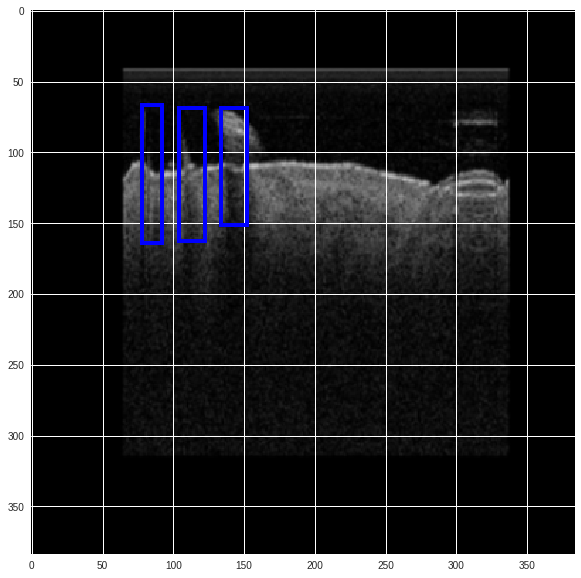

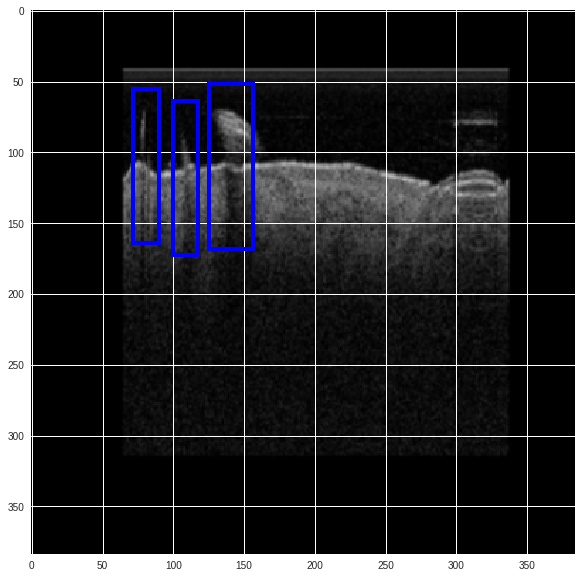

In [116]:
num = 32

## 32, 17, 39, 8, 19, 42, 44
print("Picture num =", str(num))

img = X_test[num]
comparePrediction(img, Y_test[num])

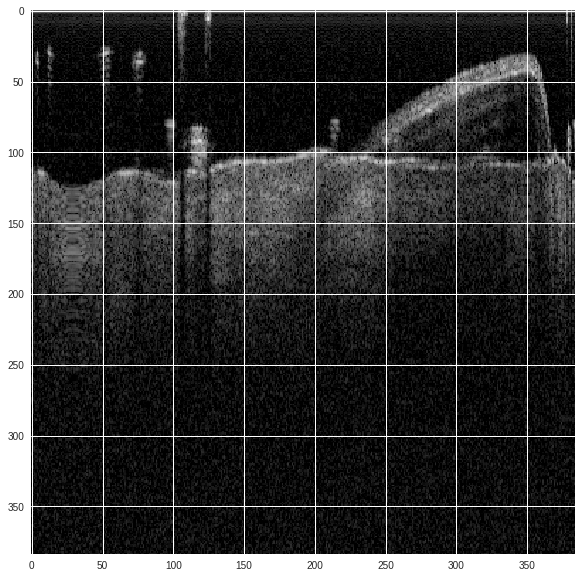

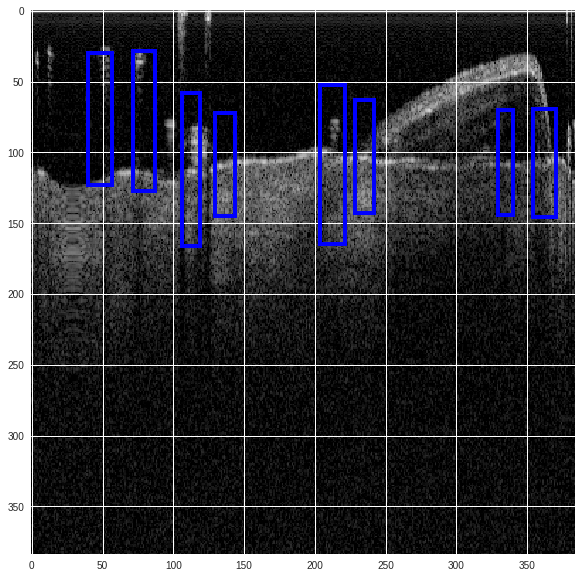

In [119]:
group = "J"
path = "/content/gdrive/My Drive/Colab/datasets/" + group +"/" + group +"_data/0025.png"
img = image.load_img(path, target_size=(resizedWidth, resizedWidth))
img = image.img_to_array(img) / 255.0

fig, ax = plt.subplots(figsize = (gridCount, 10))
ax.imshow(img)

img = (img - 0.5) * 2.0

predictUnlabeled(img)